## Vision Transformer with a Linear Layer

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.datasets import ImageFolder
import timm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, fbeta_score
import netron


**Data Preprocessing, Transforms**

In [2]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to fit the model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Create datasets
train_dataset = ImageFolder(root='/Users/TennisPhysics/Downloads/wildfire/train', transform=transform)
val_dataset = ImageFolder(root='/Users/TennisPhysics/Downloads/wildfire/valid', transform=transform)
test_dataset = ImageFolder(root='/Users/TennisPhysics/Downloads/wildfire/test', transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


**Model Training**

In [3]:
# Define the model
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify the model's head for binary classification
num_features = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(num_features, 1),  # Output size 1 for binary classification
    nn.Sigmoid()  # Sigmoid activation for binary classification
)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [4]:
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

best_val_loss = np.inf
early_stopping_patience = 3
early_stopping_counter = 0
best_epoch = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        
        predicted = torch.round(outputs)
        total += labels.size(0)
        correct += (predicted == labels.float().view(-1, 1)).sum().item()
    
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = correct / total
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.float().view(-1, 1))
            val_loss += loss.item() * images.size(0)
            
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels.float().view(-1, 1)).sum().item()
    
    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_accuracy = correct / total
    
    # Output training and validation statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Train Accuracy: {epoch_train_accuracy:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, "
          f"Val Accuracy: {epoch_val_accuracy:.4f}")
    
    # Save model if validation loss has decreased
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        
    # Early stopping
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}, best epoch was {best_epoch+1} with val loss {best_val_loss:.4f}")
        break

Epoch [1/10], Train Loss: 0.3272, Train Accuracy: 0.8828, Val Loss: 0.2391, Val Accuracy: 0.9106
Epoch [2/10], Train Loss: 0.2847, Train Accuracy: 0.8885, Val Loss: 0.2530, Val Accuracy: 0.9030
Epoch [3/10], Train Loss: 0.2744, Train Accuracy: 0.8941, Val Loss: 0.2627, Val Accuracy: 0.9003
Epoch [4/10], Train Loss: 0.2943, Train Accuracy: 0.8813, Val Loss: 0.2920, Val Accuracy: 0.8817
Early stopping at epoch 4, best epoch was 1 with val loss 0.2391


In [29]:
# Test Set Evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_loss = 0.0
correct = 0
total = 0
test_labels = []  
test_preds = []   

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels.float().view(-1, 1))
        test_loss += loss.item() * images.size(0)
        
        predicted = torch.round(outputs)
        test_preds += predicted.cpu().tolist()  # Store predictions
        test_labels += labels.cpu().tolist()   # Store ground truth labels
        total += labels.size(0)
        correct += (predicted == labels.float().view(-1, 1)).sum().item()

test_accuracy = correct / total
test_loss = test_loss / len(test_dataset)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(test_labels, test_preds))

# F1 Score
f1 = f1_score(test_labels, test_preds)
print(f"F1 Score: {f1:.4f}")

# F2 Score (beta=2)
f2 = fbeta_score(test_labels, test_preds, beta=2)
print(f"F2 Score: {f2:.4f}")


Test Loss: 0.2175, Test Accuracy: 0.9162
Confusion Matrix:
[[2373  447]
 [  81 3399]]
F1 Score: 0.9279
F2 Score: 0.9566


In [11]:
torch.onnx.export(model, torch.randn(1, 3, 224, 224), "best_model.onnx", export_params=True)
netron.start("best_model.onnx")


Serving 'best_model.onnx' at http://localhost:8080


('localhost', 8080)

In [30]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, fbeta_score

# Load the pretrained ViT model
model_fun = timm.create_model('vit_base_patch16_224', pretrained=True)
model_fun.eval()

# Extract features using the pretrained ViT model
def extract_features(loader):
    features = []
    labels = []
    with torch.no_grad():
        for images, labels_batch in loader:
            features_batch = model_fun(images).detach().cpu().numpy()
            features.append(features_batch)
            labels.append(labels_batch.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features from train, validation, and test sets
train_features, train_labels = extract_features(train_loader)
val_features, val_labels = extract_features(val_loader)
test_features, test_labels = extract_features(test_loader)

# Reshape features for sklearn's AdaBoost classifier
train_features = train_features.reshape(len(train_features), -1)
val_features = val_features.reshape(len(val_features), -1)
test_features = test_features.reshape(len(test_features), -1)

# Create and train AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)
adaboost_classifier.fit(train_features, train_labels)

# Predictions on training set
train_predictions = adaboost_classifier.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Accuracy:", train_accuracy)

# Predictions on validation set
val_predictions = adaboost_classifier.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Accuracy:", val_accuracy)

# Predictions on test set
test_predictions = adaboost_classifier.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

# Confusion Matrix
print("Confusion Matrix (Test):")
print(confusion_matrix(test_labels, test_predictions))

# F1 Score
f1 = f1_score(test_labels, test_predictions)
print("F1 Score:", f1)

# F2 Score (beta=2)
f2 = fbeta_score(test_labels, test_predictions, beta=2)
print("F2 Score:", f2)

Training Accuracy: 0.9419504132231405
Validation Accuracy: 0.9395238095238095
Test Accuracy: 0.9446031746031746
Confusion Matrix (Test):
[[2675  145]
 [ 204 3276]]
F1 Score: 0.9494276191856253
F2 Score: 0.9445822040251427


## AdaBoost Classifier with RGB feature extraction

In [39]:
import os
import cv2
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score

**Data Preprocessing**
<br> Calculate histograms of color distributions in the images. Divide the color space into bins and count the number of pixels falling into each bin.

In [49]:
# Function to extract color histograms from images
def extract_color_histogram(image_path, bins=(8, 8, 8)):
    # Read the image
    image = cv2.imread(image_path)
    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Calculate the 3D histogram
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    # Normalize the histogram
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Function to load images and extract features
def load_images_and_extract_features(root_directory):
    features = []
    labels = []
    for subdir in os.listdir(root_directory):
        subdir_path = os.path.join(root_directory, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                image_path = os.path.join(subdir_path, filename)
                # Extract color histogram features
                hist = extract_color_histogram(image_path)
                features.append(hist)
                # Assign label based on folder name
                if subdir == 'wildfire':
                    labels.append(1)  # wildfire class
                else:
                    labels.append(0)  # no wildfire class
    return np.array(features), np.array(labels)

# Paths to train, validation, and test directories
train_directory = "/Users/TennisPhysics/Downloads/wildfire/train"
valid_directory = "/Users/TennisPhysics/Downloads/wildfire/valid"
test_directory = "/Users/TennisPhysics/Downloads/wildfire/test"

# Load train and validation data
train_features, train_labels = load_images_and_extract_features(train_directory)
valid_features, valid_labels = load_images_and_extract_features(valid_directory)
test_features, test_labels = load_images_and_extract_features(test_directory)


Premature end of JPEG file
Premature end of JPEG file


**Model Training**

In [41]:
# Create AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train AdaBoost classifier using color histogram features
adaboost_classifier.fit(train_features, train_labels)

# Predictions on training set
train_predictions = adaboost_classifier.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Accuracy:", train_accuracy)

# Predictions on validation set
valid_predictions = adaboost_classifier.predict(valid_features)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
print("Validation Accuracy:", valid_accuracy)

# Predictions on test set
test_predictions = adaboost_classifier.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.9498842975206612
Validation Accuracy: 0.9517460317460318
Test Accuracy: 0.9571428571428572


**Error Metrics**

AdaBoost Classifier with RGB feature extraction
Training Accuracy: 0.9498842975206612
Validation Accuracy: 0.9517460317460318
Test Accuracy: 0.9571428571428572
Test Precision: 0.967930029154519
Test Recall: 0.9540229885057471
F1 Beta: 0.9609261939218524
F2 Beta: 0.956772334293948

Confusion Matrix (Test):
 [[2710  110]
 [ 160 3320]]


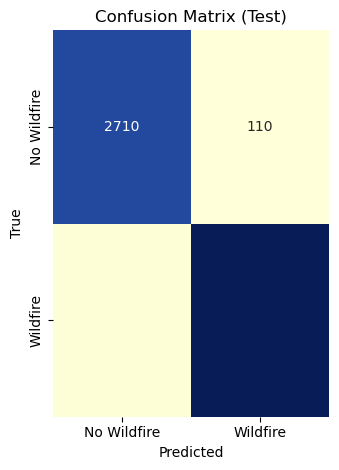

In [42]:
print("AdaBoost Classifier with RGB feature extraction")

# Calculate accuracy on validation and test data
train_accuracy = accuracy_score(train_labels, train_predictions)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", valid_accuracy)
print("Test Accuracy:", test_accuracy)

# Calculate precision and recall
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)

print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

# Calculate f-beta scores
f1 = fbeta_score(test_labels, test_predictions, beta=1, average='binary')
f2 = fbeta_score(test_labels, test_predictions, beta=2, average='binary')

print("F1 Beta:", f1)
print("F2 Beta:", f2)

# Calculate confusion matrices
valid_conf_matrix = confusion_matrix(valid_labels, valid_predictions)
test_conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix using seaborn
test_conf_matrix = confusion_matrix(test_labels, test_predictions)
print("\nConfusion Matrix (Test):\n", test_conf_matrix)

plt.subplot(1, 2, 2)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False,
            xticklabels=['No Wildfire', 'Wildfire'], yticklabels=['No Wildfire', 'Wildfire'])
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

## AdaBoost with Downsampling -> RGB Feature Extraction

In [43]:
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.measure import block_reduce

# Function to extract color histograms from images
def extract_color_histogram(image_path, bins=(8, 8, 8), DOWNSAMPLE_FACTOR=7):
    # Read the image
    image = cv2.imread(image_path)
    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Downsample image
    if DOWNSAMPLE_FACTOR != 1:
        image = block_reduce(image, block_size=(DOWNSAMPLE_FACTOR, DOWNSAMPLE_FACTOR, 1), func=np.max)
    # Calculate the 3D histogram
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    # Normalize the histogram
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Function to load images and extract features
def load_images_and_extract_features(root_directory, DOWNSAMPLE_FACTOR=7):
    features = []
    labels = []
    for subdir in os.listdir(root_directory):
        subdir_path = os.path.join(root_directory, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                image_path = os.path.join(subdir_path, filename)
                # Extract color histogram features
                hist = extract_color_histogram(image_path, DOWNSAMPLE_FACTOR=DOWNSAMPLE_FACTOR)
                features.append(hist)
                # Assign label based on folder name
                if subdir == 'wildfire':
                    labels.append(1)  # wildfire class
                else:
                    labels.append(0)  # no wildfire class
    return np.array(features), np.array(labels)

# Paths to train, validation, and test directories
train_directory = "/Users/TennisPhysics/Downloads/wildfire/train"
valid_directory = "/Users/TennisPhysics/Downloads/wildfire/valid"
test_directory = "/Users/TennisPhysics/Downloads/wildfire/test"

# Load train and validation data with downsampling
train_features, train_labels = load_images_and_extract_features(train_directory)
valid_features, valid_labels = load_images_and_extract_features(valid_directory)
test_features, test_labels = load_images_and_extract_features(test_directory)


Premature end of JPEG file
Premature end of JPEG file


In [44]:
# Create AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train AdaBoost classifier using color histogram features
adaboost_classifier.fit(train_features, train_labels)

# Predictions on training set
train_predictions = adaboost_classifier.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Accuracy:", train_accuracy)

# Predictions on validation set
valid_predictions = adaboost_classifier.predict(valid_features)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
print("Validation Accuracy:", valid_accuracy)

# Predictions on test set
test_predictions = adaboost_classifier.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.9439338842975207
Validation Accuracy: 0.9480952380952381
Test Accuracy: 0.949047619047619


AdABoost Classifier with Downsampling -> RGB feature extraction
Training Accuracy: 0.9439338842975207
Validation Accuracy: 0.9480952380952381
Test Accuracy: 0.949047619047619
Test Precision: 0.9540097729232538
Test Recall: 0.953735632183908
F1 Beta: 0.9538726828567323
F2 Beta: 0.9537904477268807

Confusion Matrix (Test):
 [[2660  160]
 [ 161 3319]]


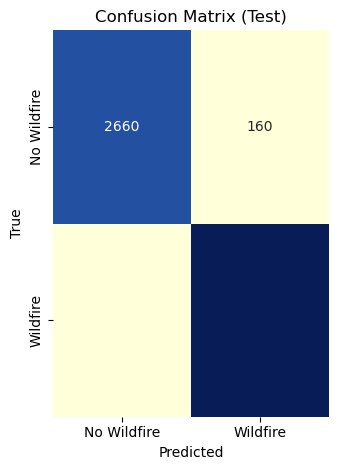

In [45]:
# Calculate accuracy on validation and test data
print("AdABoost Classifier with Downsampling -> RGB feature extraction")

train_accuracy = accuracy_score(train_labels, train_predictions)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", valid_accuracy)
print("Test Accuracy:", test_accuracy)

# Calculate precision and recall
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)

print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

# Calculate f-beta scores
f1 = fbeta_score(test_labels, test_predictions, beta=1, average='binary')
f2 = fbeta_score(test_labels, test_predictions, beta=2, average='binary')

print("F1 Beta:", f1)
print("F2 Beta:", f2)

# Calculate confusion matrices
valid_conf_matrix = confusion_matrix(valid_labels, valid_predictions)
test_conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix using seaborn
test_conf_matrix = confusion_matrix(test_labels, test_predictions)
print("\nConfusion Matrix (Test):\n", test_conf_matrix)

plt.subplot(1, 2, 2)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False,
            xticklabels=['No Wildfire', 'Wildfire'], yticklabels=['No Wildfire', 'Wildfire'])
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

## Gradient Boosting Classifier with RGB feature extraction

**Model Training**

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

# Create Gradient Boosting classifier
gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train Gradient Boosting classifier using color histogram features
gradient_boosting_classifier.fit(train_features, train_labels)

# Predictions on training set
train_predictions = gradient_boosting_classifier.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
print("Training Accuracy:", train_accuracy)

# Predictions on validation set
valid_predictions = gradient_boosting_classifier.predict(valid_features)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
print("Validation Accuracy:", valid_accuracy)

# Predictions on test set
test_predictions = gradient_boosting_classifier.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

Training Accuracy: 0.9658512396694214
Validation Accuracy: 0.9658730158730159
Test Accuracy: 0.9696825396825397


**Error Metrics**

Gradient Boosting Classifier with RGB feature extraction
Training Accuracy: 0.9658512396694214
Validation Accuracy: 0.9658730158730159
Test Accuracy: 0.9696825396825397
Test Precision: 0.9804265264387964
Test Recall: 0.964367816091954
F1 Beta: 0.9723308706359554
F2 Beta: 0.9675373349478175

Confusion Matrix (Test):
 [[2753   67]
 [ 124 3356]]


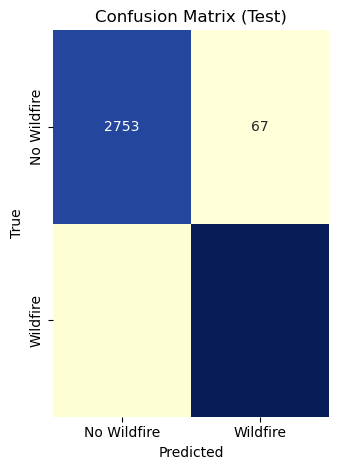

In [51]:
print("Gradient Boosting Classifier with RGB feature extraction")
# Calculate accuracy on validation and test data
train_accuracy = accuracy_score(train_labels, train_predictions)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", valid_accuracy)
print("Test Accuracy:", test_accuracy)

# Calculate precision and recall
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)

print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

# Calculate f-beta scores
f1 = fbeta_score(test_labels, test_predictions, beta=1, average='binary')
f2 = fbeta_score(test_labels, test_predictions, beta=2, average='binary')

print("F1 Beta:", f1)
print("F2 Beta:", f2)

# Calculate confusion matrices
valid_conf_matrix = confusion_matrix(valid_labels, valid_predictions)
test_conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix using seaborn
test_conf_matrix = confusion_matrix(test_labels, test_predictions)
print("\nConfusion Matrix (Test):\n", test_conf_matrix)

plt.subplot(1, 2, 2)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False,
            xticklabels=['No Wildfire', 'Wildfire'], yticklabels=['No Wildfire', 'Wildfire'])
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

## Naive Bayes with RGB feature extraction

In [20]:
import os
import cv2
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix,fbeta_score 
import seaborn as sns
import matplotlib.pyplot as plt


**Data Preprocessing**
<br> Calculate histograms of color distributions in the images. Divide the color space into bins and count the number of pixels falling into each bin.

In [21]:
# Function to extract color histograms from images
def extract_color_histogram(image_path, bins=(8, 8, 8)):
    # Read the image
    image = cv2.imread(image_path)
    # Convert the image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Calculate the 3D histogram
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    # Normalize the histogram
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# Function to load images and extract features
def load_images_and_extract_features(root_directory):
    features = []
    labels = []
    for subdir in os.listdir(root_directory):
        subdir_path = os.path.join(root_directory, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                image_path = os.path.join(subdir_path, filename)
                # Extract color histogram features
                hist = extract_color_histogram(image_path)
                features.append(hist)
                # Assign label based on folder name
                if subdir == 'wildfire':
                    labels.append(1)  # wildfire class
                else:
                    labels.append(0)  # no wildfire class
    return np.array(features), np.array(labels)

# Paths to train, validation, and test directories
train_directory = "/Users/TennisPhysics/Downloads/wildfire/train"
valid_directory = "/Users/TennisPhysics/Downloads/wildfire/valid"
test_directory = "/Users/TennisPhysics/Downloads/wildfire/test"

# Load train and validation data
train_features, train_labels = load_images_and_extract_features(train_directory)
valid_features, valid_labels = load_images_and_extract_features(valid_directory)
test_features, test_labels = load_images_and_extract_features(test_directory)


Premature end of JPEG file
Premature end of JPEG file


**Model Training**

In [22]:
# Initialize and train Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(train_features, train_labels)

# Predict on validation and test data
train_predictions = nb_model.predict(train_features)
valid_predictions = nb_model.predict(valid_features)
test_predictions = nb_model.predict(test_features)


**Error Metrics**

Training Accuracy: 0.8040661157024793
Validation Accuracy: 0.8228571428571428
Test Accuracy: 0.8244444444444444
F1 Beta: 0.8603535353535353
F2 Beta: 0.9278322440087147

Confusion Matrix (Test):
 [[1787 1033]
 [  73 3407]]


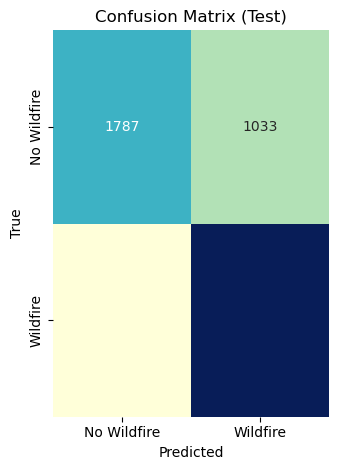

In [24]:
# Calculate accuracy on validation and test data
train_accuracy = accuracy_score(train_labels, train_predictions)
valid_accuracy = accuracy_score(valid_labels, valid_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", valid_accuracy)
print("Test Accuracy:", test_accuracy)

# Calculate f-beta scores
f1 = fbeta_score(test_labels, test_predictions, beta=1, average='binary')
f2 = fbeta_score(test_labels, test_predictions, beta=2, average='binary')

print("F1 Beta:", f1)
print("F2 Beta:", f2)

# Calculate confusion matrices
valid_conf_matrix = confusion_matrix(valid_labels, valid_predictions)
test_conf_matrix = confusion_matrix(test_labels, test_predictions)

# Plot confusion matrix using seaborn
test_conf_matrix = confusion_matrix(test_labels, test_predictions)
print("\nConfusion Matrix (Test):\n", test_conf_matrix)

plt.subplot(1, 2, 2)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='YlGnBu', cbar=False,
            xticklabels=['No Wildfire', 'Wildfire'], yticklabels=['No Wildfire', 'Wildfire'])
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()